In [3]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
from pprint import pprint
from glob import glob

In [4]:
%load_ext autoreload
%autoreload 1
%aimport data_utils
%aimport contrastive_data
%aimport sc_eVIP.score

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from contrastive_data import *
from data_utils import *
from main import *
from models import *
from scoring import *


In [6]:
from sc_eVIP import score as sceVIP_score

# Data

In [29]:
gene = 'KRAS'
data_path = f'/home/lguirardel/data/perturb_comp/data/{gene}/'


In [8]:
group_wt_like = True
paths = get_paths(data_path)
counts = load_data(*paths, group_wt_like=False)

	Reading files...
		Reading matrix


		Reading genes and cells
		Reading variant data
	Merging and processing...
		97 variant classes


In [9]:
metadata = pd.read_csv(paths[4], index_col=0) # contains T2 scores and control status
metadata['Control status'].value_counts()

Control status
unknown       75
synonymous    16
ExAC          10
Name: count, dtype: int64

In [40]:
control_status = metadata['Control status'].dropna().isin(['synonymous'])
control_status.value_counts()


Control status
False    85
True     16
Name: count, dtype: int64

# PCA

Reproduce results from Ursu et al. They used all data, and so will we here

In [42]:
pca = PCA(20)
df = counts.drop(columns=['variant','Variant functional class',])
X_red = pca.fit_transform(df)
X_red = pd.DataFrame(X_red, index = df.index)

In [43]:
result = sceVIP_score.compare_groups_with_reference(

    X_red,
    pd.DataFrame(counts.variant.rename('label')),
    groups=counts.variant.unique(),
    controls=control_status[control_status].index,
    n_bootstrap_controls=0
)

Found 15/15 controls
1 %

100 %

In [44]:
result

,HotellingT2.mean,HotellingT2.ci.0.95.low,HotellingT2.ci.0.95.high,avg.pearson.mean,avg.pearson.ci.0.95.low,avg.pearson.ci.0.95.high,HotellingT2.q,avg.pearson.q
Q61L,9545.077379,9207.952076,9882.202681,1.952849,1.940025,1.965672,0.000010,0.000010
T50P,234.230754,214.022122,254.439386,0.216764,0.188737,0.244791,0.000010,0.000010
K179R,30.174098,25.394844,34.953351,0.052219,0.039188,0.065251,0.641988,0.643551
Q61H,7329.338691,7063.585768,7595.091615,1.952704,1.943819,1.961589,0.000010,0.000010
S17S,45.929509,36.741381,55.117637,0.082242,0.058781,0.105702,0.478740,0.496894
...,...,...,...,...,...,...,...,...
V112I,35.308258,30.708527,39.907989,0.054983,0.044594,0.065372,0.579048,0.644377
T74A,437.732326,398.346693,477.11796,0.614342,0.559124,0.66956,0.000010,0.000010
A66A,34.696921,28.033361,41.360481,0.054518,0.039139,0.069897,0.591174,0.646465
T158A,34.635114,28.495054,40.775173,0.046544,0.031713,0.061376,0.591174,0.676885


        Recomputed        Paper
M111L    26.159489    26.248723
S136N    26.775477    26.672454
K179R    30.174098    29.958400
V8V      29.985586    30.347129
T144T    30.529906    30.545139
...            ...          ...
G13E   8575.524673  8531.829620
K117N  8819.639798  8784.743760
Q61R   9103.686674  9063.812540
Q61L   9545.077379  9515.380160
G13R   9592.302264  9582.732490

[97 rows x 2 columns]


''

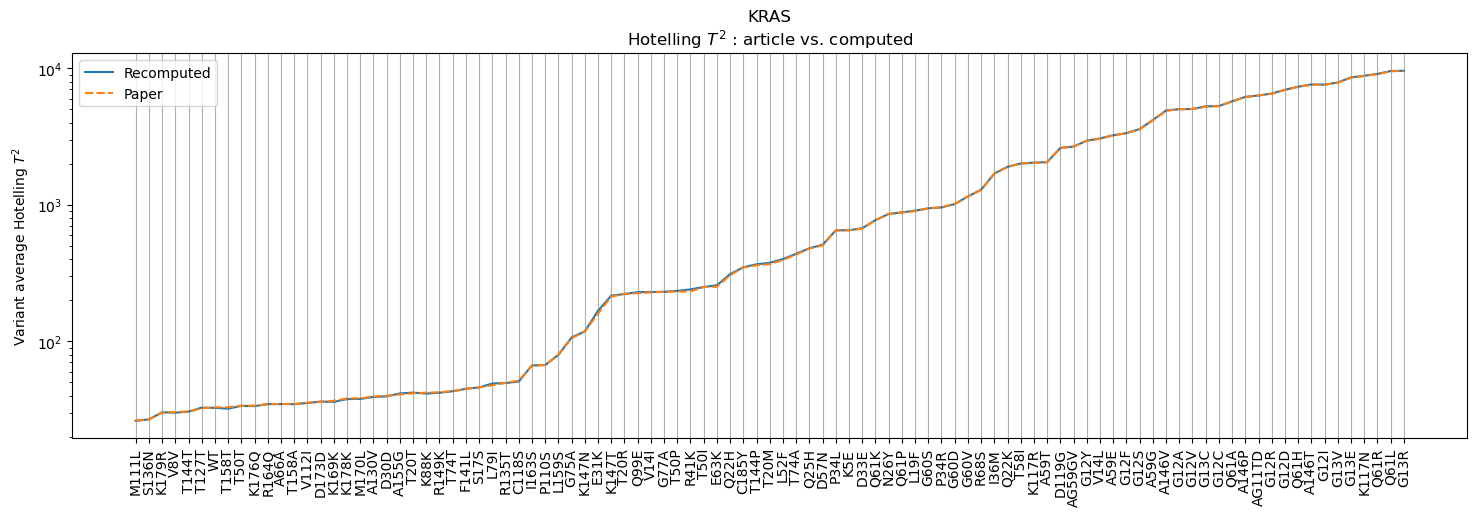

In [55]:
plt.gcf().set_size_inches(18, 5);
df = pd.concat((result['HotellingT2.mean'].rename('Recomputed'), metadata['HotellingT2'].rename('Paper')), axis=1).dropna()
df = df.sort_values('Paper')
sns.lineplot(data=df, )
print(df)
plt.yscale('log')
plt.xticks(rotation=90)
plt.title(f'{gene}\nHotelling $T^2$ : article vs. computed')
plt.ylabel('Variant average Hotelling $T^2$')
plt.grid(axis='x');


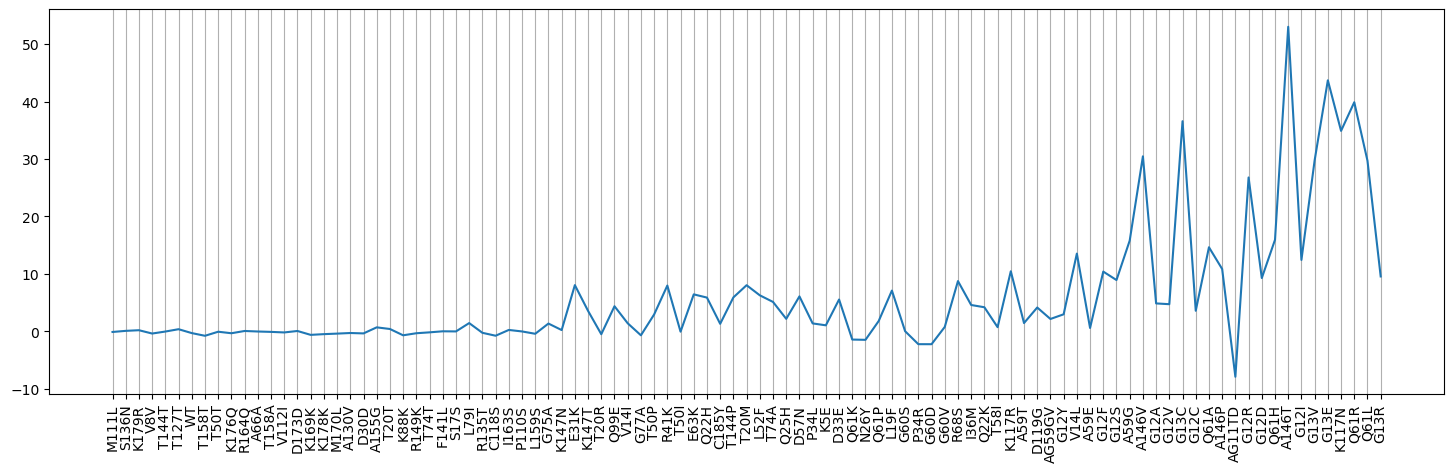

In [56]:
plt.gcf().set_size_inches(18, 5);
plt.xticks(rotation=90)
plt.grid(axis='x')
plt.plot(df.Recomputed - df.Paper)

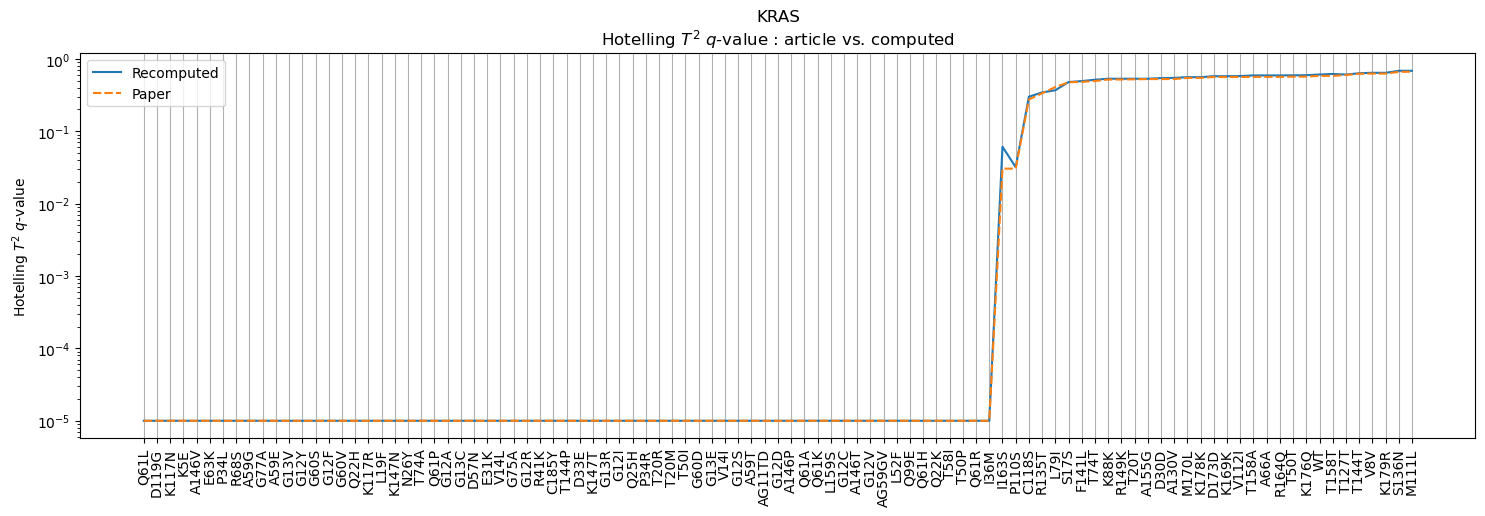

In [53]:
plt.gcf().set_size_inches(18, 5);
df = pd.concat((result['HotellingT2.q'].rename('Recomputed'), metadata['HotellingT2.q'].rename('Paper')), axis=1).dropna()
df = df.sort_values('Paper')
sns.lineplot(data=df, )
# print(df)
plt.grid(axis='x')
plt.yscale('log')
plt.xticks(rotation=90)
plt.title(f'{gene}\nHotelling $T^2$ $q$-value : article vs. computed')
plt.ylabel('Hotelling $T^2$ $q$-value');

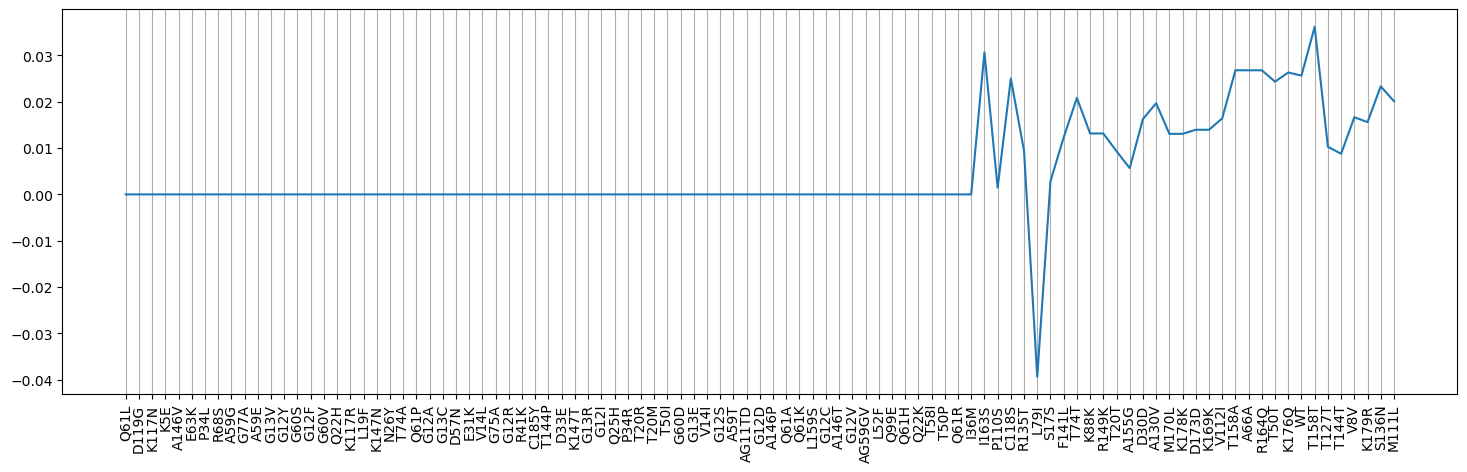

In [54]:
plt.gcf().set_size_inches(18, 5);
plt.xticks(rotation=90)
plt.grid(axis='x')
plt.plot(df.Recomputed - df.Paper)